# Stock Price Prediction
https://medium.com/@randerson112358/stock-price-prediction-using-python-machine-learning-e82a039ac2bb
https://www.youtube.com/watch?v=QIUxPv5PJOY&feature=emb_title


In [168]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.tensorboard import SummaryWriter

import numpy as np

from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import pandas_datareader as web

plt.style.use('fivethirtyeight')

# 为实验结果可复现
# random.seed(233)
np.random.seed(233)
torch.manual_seed(233)

USE_CUDA = torch.cuda.is_available()

logdir = 'D:\WORK\Program\Python\pytorch\logs'
writer = SummaryWriter(logdir, flush_secs=60)

In [169]:
EPOCHS = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-3

## Get the stock quote

In [170]:
# df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
# df.to_csv('data/StockPrice/AAPL.csv')
df = pd.read_csv('data/Stock/AAPL.csv')
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.691425
1,2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.759631
2,2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.901293
3,2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.036158
4,2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,13.015480
...,...,...,...,...,...,...,...
1998,2019-12-11,67.775002,67.125000,67.202499,67.692497,78756800.0,67.228699
1999,2019-12-12,68.139999,66.830002,66.945000,67.864998,137310400.0,67.400017
2000,2019-12-13,68.824997,67.732498,67.864998,68.787498,133587600.0,68.316193
2001,2019-12-16,70.197502,69.245003,69.250000,69.964996,128186000.0,69.485619


## Visualize the data

Text(0, 0.5, 'Close Price USD')

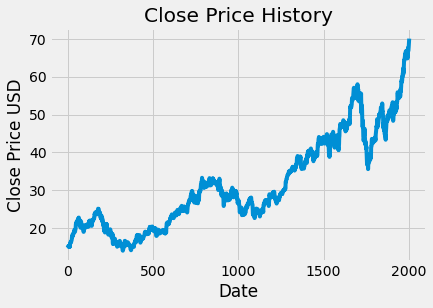

In [171]:
# plt.figure(figsize=())
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
# plt.grid()

In [172]:
print(type(df['Close']), df['Close'])
print(type(df.filter(['Close'])), df.filter(['Close']))

<class 'pandas.core.series.Series'> 0       14.686786
1       14.765715
2       14.929643
3       15.085714
4       15.061786
          ...    
1998    67.692497
1999    67.864998
2000    68.787498
2001    69.964996
2002    70.102501
Name: Close, Length: 2003, dtype: float64
<class 'pandas.core.frame.DataFrame'>           Close
0     14.686786
1     14.765715
2     14.929643
3     15.085714
4     15.061786
...         ...
1998  67.692497
1999  67.864998
2000  68.787498
2001  69.964996
2002  70.102501

[2003 rows x 1 columns]


In [173]:
data_frame = df.filter(['Close'])
data = data_frame.values
print(data)
type(data)

[[14.6867857 ]
 [14.76571465]
 [14.92964268]
 ...
 [68.78749847]
 [69.96499634]
 [70.10250092]]


numpy.ndarray

In [174]:
train_data_len = int(len(data) * .8)
print(train_data_len, len(data) - train_data_len)

1602 401


## 归一化
https://blog.csdn.net/z_feng12489/article/details/89205558  
- MinMaxScaler
    - $\frac{x-min}{max-min}$
    - 当有新数据加入时，可能导致max和min的变化，需要重新定义。对于outlier非常敏感，因为outlier影响了max或min值，所以这种方法只适用于数据在一个范围内分布的情况。  
- transforms.Normalize
    - $\frac{x-\mu}{\sigma}$

In [175]:
transform_data = data[:train_data_len]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(transform_data)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transformed_data = transform(transform_data)

print(scaled_data, transformed_data)



[[0.02202713]
 [0.02437883]
 [0.02926309]
 ...
 [0.98919928]
 [0.98592179]
 [0.97318442]] tensor([[[28.3736],
         [28.5314],
         [28.8593],
         ...,
         [93.2950],
         [93.0750],
         [92.2200]]], dtype=torch.float64)


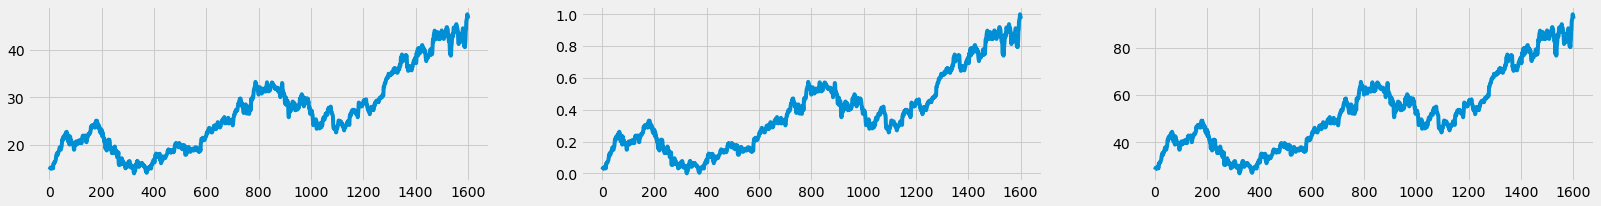

In [176]:
# 归一化数据与原数据对比

fig = plt.figure(figsize=(25, 3))
for i, d in  enumerate([transform_data, scaled_data.squeeze(), transformed_data.squeeze()]):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(d)

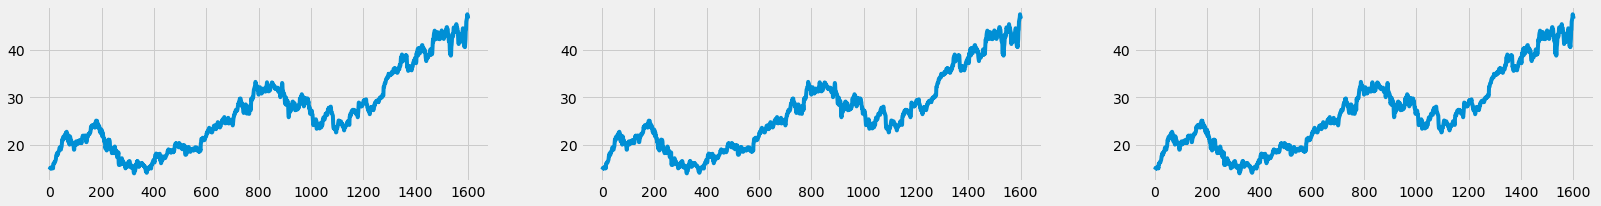

In [177]:
# 反归一化
fig = plt.figure(figsize=(25, 3))
for i, d in enumerate([transform_data, scaler.inverse_transform(scaled_data), (transformed_data * .5 + .5).squeeze()]):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(d)

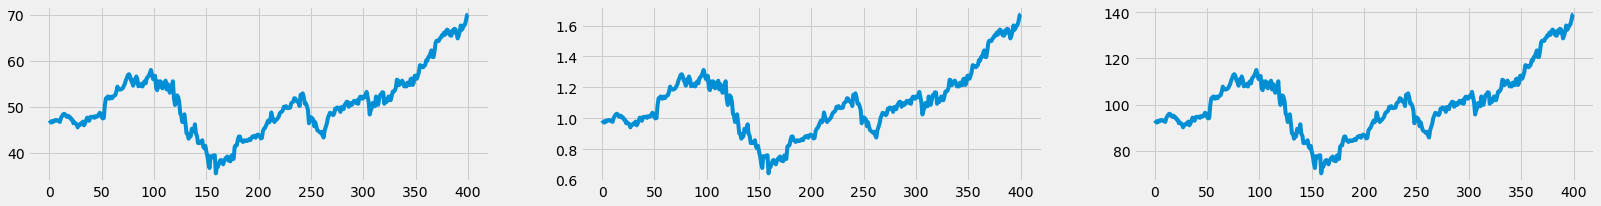

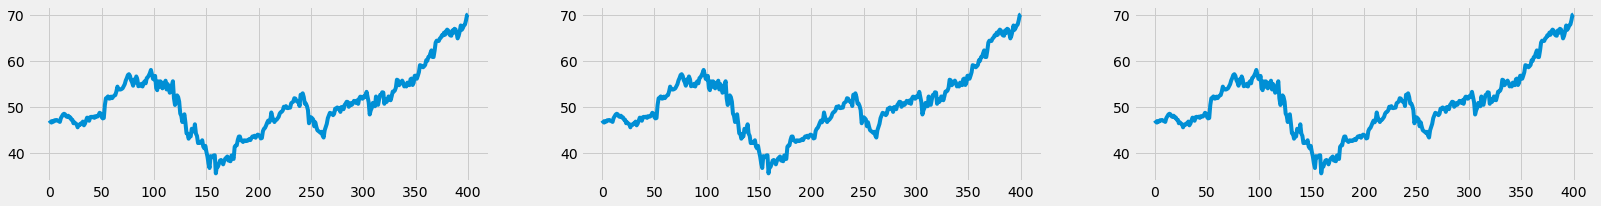

In [178]:
# 新数据对归一化影响
untransform_data = data[train_data_len:]
fig = plt.figure(figsize=(25, 3))
for i, d in enumerate([untransform_data, scaler.transform(untransform_data), transform(untransform_data).squeeze()]):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(d)

fig = plt.figure(figsize=(25, 3))
for i, d in enumerate([untransform_data, scaler.inverse_transform(scaler.transform(untransform_data)), (transform(untransform_data) * .5 + .5).squeeze()]):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(d)


In [179]:
scaled_data = scaler.fit_transform(data)

transformed_data = transforms.Normalize(0.5, 0.5)(torch.from_numpy(data).view(1, 2003, 1))

# print(scale.ta_max_, scaler.data_min_)
scaler.inverse_transform([[2]])

array([[126.2575016]])

In [180]:
x = [scaled_data[i - 60 : i] for i in range(60, len(data))]
y = scaled_data[60 : ]

print(len(x), len(y))
x, y = [torch.tensor(i).float() for i in [x, y]]
x.squeeze_()
y.squeeze_()

print(x.shape, y.shape)

1943 1943
torch.Size([1943, 60]) torch.Size([1943])


In [181]:
class CustomDataset(Data.Dataset):
    def __init__(self, x:torch.Tensor, y:torch.Tensor):
        self.x = x
        self.y = y

    def __getitem__(self, index:int):
        return self.x[index], self.y[index].item()

    def __len__(self):
        return len(self.x)

In [182]:
train_set = CustomDataset(x[ : train_data_len-60], y[ : train_data_len-60])
# test_set = [x[train_data_len-60 : ], y[train_data_len-60 :]]

print(len(train_set))


1542


In [183]:
train_loader = Data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [184]:
bat_x, bat_y = next(iter(train_loader))
print(bat_x.shape, bat_y.shape)
print(bat_x.dtype, bat_y.dtype)

torch.Size([16, 60]) torch.Size([16])
torch.float32 torch.float64


In [185]:
# class LSTMModel(nn.Module):
#     def __init__(self):
#         super(NNModel, self).__init__()
#         self.LSTM =Sequential(
#             # nn.LSTM()
#         )
    
#     def forward(self, x):
#         pass

class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init()
        # self.conv = nn.Conv1d()


class LSTMModel(nn.Module):
    def __init__(self, in_feature=60, hidden_feature=64, num_class=1, num_layers=2):
        super(LSTMModel, self).__init__()
        self.rnn = nn.LSTM(in_feature, hidden_feature, num_layers)
        self.line = nn.Linear(hidden_feature, num_class)
          
    def forward(self, x):
        x = x.permute(2, 0, 1)
        out, _ = self.rnn(x)
        out = out[-1,:,:]
        out = self.line(out)
        return out
        

In [186]:
model = nn.Sequential(
    nn.Linear(60, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# nn.init.normal_(model[0].weight)
# nn.init.normal_(model[2].weight)
# nn.init.normal_(model[4].weight)

# a=1
# model = LSTMModel()

In [187]:
loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

In [188]:
epoch_size = len(train_set) / BATCH_SIZE
model.train()
for epoch in range(EPOCHS):
    for it, (batchX, batchY) in enumerate(train_loader):
        y_pred = model(batchX)
        
        loss = loss_fn(y_pred, batchY.float())
        # print(it, loss.item())

        optimizer.zero_grad()
        loss.backward()

        step = epoch * epoch_size + it
        # writer.add_scalar('train_loss', loss, step)
        print(step, loss.item())

        optimizer.step()

        # for name, param in model.named_parameters():
        #     if 'linear' in name:
        #         # print(name)
        #         writer.add_histogram(name, param, step)
    # print(epoch, loss.item())

1612.0 6.029092788696289
11613.0 1.4128683805465698
11614.0 8.781002044677734
11615.0 4.67805290222168
11616.0 7.105257511138916
11617.0 7.103392124176025
11618.0 4.601754188537598
11619.0 4.014787673950195
11620.0 4.172633171081543
11621.0 7.882037162780762
11622.0 3.9863314628601074
11623.0 5.121609687805176
11624.0 3.8733811378479004
11625.0 2.1648764610290527
11626.0 6.663773536682129
11627.0 6.25499963760376
11628.0 3.7267990112304688
11629.0 5.076848030090332
11630.0 6.903012752532959
11631.0 2.3659510612487793
11632.0 7.720854759216309
11633.0 6.922735214233398
11634.0 4.971582889556885
11635.0 7.140474796295166
11636.0 5.296863079071045
11637.0 3.560460329055786
11638.0 3.3586056232452393
11639.0 4.04203462600708
11640.0 3.454616069793701
11641.0 6.383852481842041
11642.0 4.9373884201049805
11643.0 6.984543323516846
11644.0 4.98361873626709
11645.0 6.161486625671387
11646.0 2.5931549072265625
11647.0 7.733811378479004
11648.0 3.699460744857788
11649.0 9.796501159667969
11650.0 

In [189]:
model.eval()
with torch.no_grad():
    train_y_pred = model(x[ : train_data_len-60])
    test_y_pred = model(x[train_data_len-60 : ])
    train_y_pred = scaler.inverse_transform(train_y_pred)
    test_y_pred = scaler.inverse_transform(test_y_pred)
    # print(y_pred[0])
# y_pred.shape

In [190]:
# writer.add_graph(model, )

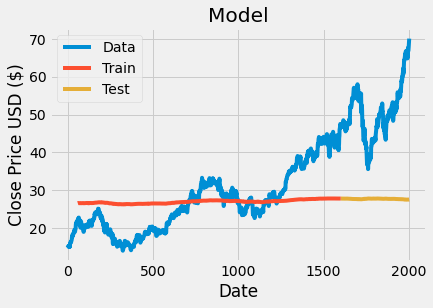

In [195]:
valid = data_frame.copy()
valid[60:train_data_len] = train_y_pred
valid[train_data_len:] = test_y_pred

plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

plt.plot(data_frame)
plt.plot(valid[60:train_data_len])
plt.plot(valid[train_data_len:])
plt.legend(['Data', 'Train', 'Test'])